In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as pdr
import plotly.graph_objects as go
import yfinance as yf
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import tensorflow as tf
import tensorflow_probability as tfp
plt.style.use('fivethirtyeight')

In [ ]:
start = dt.datetime(2015,1,1)
end = dt.datetime(2024,5,31)

In [ ]:
tsla = yf.download("TSLA", start=start, end=end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


# **Description:**

**Open** is the price of the stock at the beginning of the trading day (it need not be the closing price of the previous trading day).'

**High** is the highest price of the stock on that trading day.

**Low** is the lowest price of the stock on that trading day.

**Close** is the price of the stock at closing time. The closing price is the 'raw' price which is just the cash value of the last transacted price before the market closes.

**Volume** indicates how many stocks were traded.

**Adj Close** is the updated stock closing price that accurately reflects the stock's value after accounting for any corporate actions. It is considered to be the true price of that stock and is often used when examining historical returns or performing a detailed analysis of historical returns.

In [ ]:
tsla


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500
...,...,...,...,...,...,...
2024-05-23,181.800003,181.899994,173.259995,173.740005,173.740005,71975500
2024-05-24,174.839996,180.080002,173.729996,179.240005,179.240005,65479700
2024-05-28,176.399994,178.250000,173.160004,176.750000,176.750000,59736600


# **Exploratory Data Analysis**


###**a)Candle stick plot**

In the candlestick plots below:

**Blue** candlestick indicates a day where the closing price was higher than the open (a gain)

**Black** candlestick indicates a day where the open was higher than the close (a loss)

In [ ]:
# Create candlestick chart with custom colors
candlestick = go.Candlestick(
    x=tsla.index,
    open=tsla['Open'],
    high=tsla['High'],
    low=tsla['Low'],
    close=tsla['Close'],
    increasing_line_color='blue',  # Color for bullish candlesticks (closing price higher than opening price)
    decreasing_line_color='black',  # Color for bearish candlesticks (opening price higher than closing price)
    increasing_fillcolor='blue',   # Fill color for bullish candlesticks
    decreasing_fillcolor='black'   # Fill color for bearish candlesticks
)

# Create figure object
fig = go.Figure(data=[candlestick])

# Update layout
fig.update_layout(
    title_text='Tesla (01/2015 - 12/2023)',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=True  # Ensure the range slider is visible for interactive zooming
)

# Show the figure
fig.show()

###**b)Trends of the stock closing price of Tesla in the mentioned period**

In [ ]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=tsla.index, y=tsla['Adj Close'], line_color='black'))
fig1.update_layout(title_text='Closing Prices of Tesla Stocks (01/2015 - 12/2023)', xaxis_rangeslider_visible=True)
fig1.show()

Based on the above graph we can see that the most of the stock movement for Tesla happened between 2020 - 2023 with the highest price on Nov 2021.
Up until 2020 the price of the stock was stagnant.

###**c)Trends of the stock closing price change of Tesla in the mentioned period**

When trading, we are more concerned about the relative change in price of an asset as compared to it's absolute price.
So for that purpose we are creating a column called "Daily Returns" which calculates the the percentage change between the closing price of that day and the previous day


In [ ]:
## Daily returns in closing price
def add_daily_change_column(df, col_name):
    df['Daily Returns'] = df[col_name].pct_change()
    return df

tsla = add_daily_change_column(tsla, 'Adj Close')

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=tsla.index, y=tsla['Daily Returns'], name="Tesla", line_color='darkturquoise'))
fig2.update_layout(title_text='Stock Returns (01/2015 - 12/2023)', xaxis_rangeslider_visible=True)
fig2.show()

In [ ]:
tsla.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Returns
Date,,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,NaN
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,-0.042041
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,0.005664
2015-01-07,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,-0.001562
2015-01-08,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,-0.001564


##**Checking for stationarity**

Stationarity is a fundamental assumption for numerous time series models such as ARIMA (Auto Regression Integrated Moving Average) and SARIMA (Seasonal ARIMA). These models rely on the constancy of statistical properties like mean and variance over time. Non-stationary data can lead to unreliable model outputs and inaccurate predictions, just because the models aren’t expecting it.

Stationarity simplifies the complexities within time series data, making it easier to model and forecast than non-stationary time series. When the statistical properties of a time series remain constant over time, it’s much easier to use historical data to develop accurate models of the time series and forecast future values of the series.

###**a) Augmented Dickey Fuller Test**
This is a hypothesis test which determines whether the given time series is stationary or not.

H0: The time series is not stationary.

Ha: The time series is stationary.

We reject the hypothesis based on the p value obtained. (If p value is too low, H0 must go!!!)

**Interpreting the test statistic:** The test statistic is negative. The more negative it is, the stronger the evidence against the null hypothesis (i.e., stronger evidence for stationarity)

In [ ]:
from statsmodels.tsa.stattools import adfuller

tsla['Daily Returns'] = tsla['Close'].pct_change().dropna()
tsla = tsla.dropna(subset=['Daily Returns'])

# Perform the ADF test
adf_result = adfuller(tsla['Daily Returns'], maxlag=1)

# Print ADF statistic and p-value
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Interpretation
if adf_result[1] > 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -48.79796264456509
p-value: 0.0
The time series is stationary.


The ADF test gave a test statistic value of -32.60093 and a p value of 0.0. This means that we have enough evidence to reject the null hypotheisis which states that the time series is not stationary.

###**b) Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**
It is a test to check if a given time series is stationary or not.

H0: The given series is stationary.

Ha: The given series is not stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

result = kpss_test(tsla['Daily Returns'])

Results of KPSS Test:
Test Statistic           0.201116
p-value                  0.100000
#Lags Used               0.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<ipython-input-54-23907c97b56b>:4: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




The p value obtained is 0.1 which is greater than the threshold of 0.05. Therfore we do not have enough evidence to reject H0. Therefore we can assume that the series is stationary.

### **Auto-correlation in the closing prices**

We are plotting the ACF and PACF to have a better understanding about the stationarity of the time series.
#### **Understanding the plot**
All the bands inside the shaded region can be considered statistically insignificant. The values outside the shaded region are statistically significant.


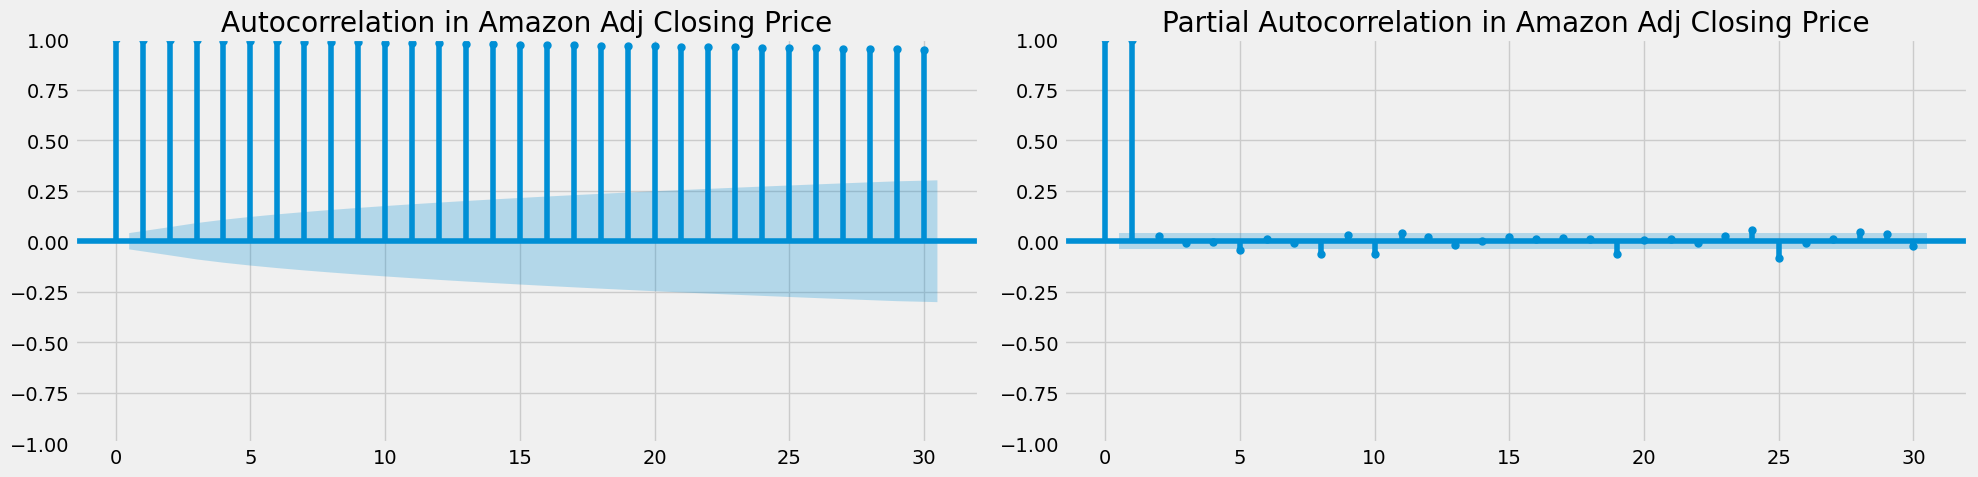

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

max_lags = 30  # Maximum number of lags to show in the plots

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# Plot autocorrelation function (ACF)
plot_acf(tsla['Adj Close'], alpha=0.05, lags=max_lags, ax=fig.axes[0], title='Autocorrelation in Amazon Adj Closing Price')

# Plot partial autocorrelation function (PACF)
plot_pacf(tsla['Adj Close'], alpha=0.05, lags=max_lags, ax=fig.axes[1], title='Partial Autocorrelation in Amazon Adj Closing Price')

# Adjust layout to prevent overlapping of titles and labels
fig.tight_layout()

# Display the plot
plt.show()


##**Decomposing the time series**
Now we are decomposing the time series into trends, seasonal and residual component.
We are assuming an additive decomposition which means that the original time series (Yt) can be represented as
#### **Yt = St + Tt + Rt**
Where St -> Seasonality component,
Tt -> Trend component,  
Rt -> Residual (reminder) component

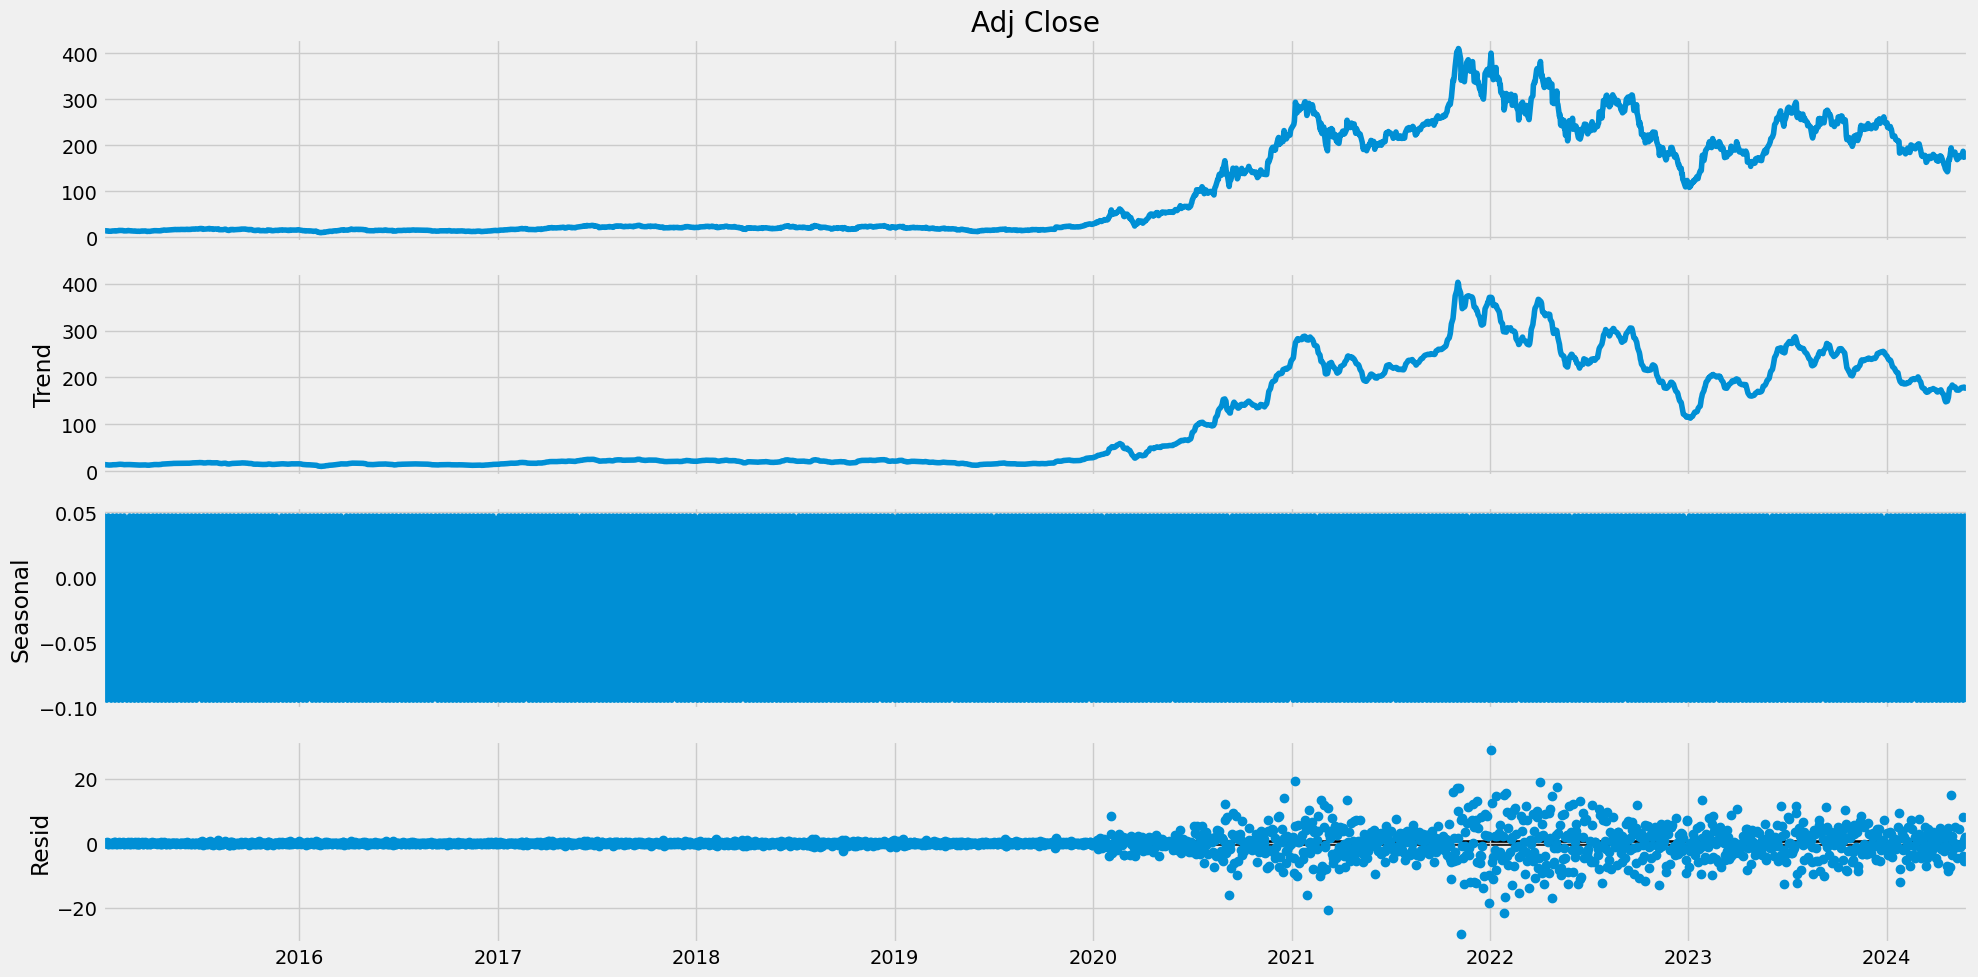

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(tsla['Adj Close'], model='additive', period=5)

# Plot the decomposition
plt.rcParams['figure.figsize'] = 20, 10
result.plot()
plt.show()


## **Building the model**

In [ ]:
data = tsla.filter(['Adj Close'])

#Convert the dataframe into a numpy array
dataset = data.values

#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)* 0.8)  # Splitting the data into a 80/20 split
training_data_len

1894

### **a) Scale the data**

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)




In [ ]:
# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

#Split the data into x_train and y_train
x_train = [] # Independent varibale
y_train = [] # Dependent variable

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=61:
    print(x_train)
    print(y_train)


[array([0.01105916, 0.0112573 , 0.01120235, 0.01114741, 0.01048805,
       0.00974712, 0.01008678, 0.008162  , 0.00802547, 0.00822527,
       0.00803546, 0.00880803, 0.00964888, 0.00959393, 0.01046974,
       0.01037483, 0.00927424, 0.01024496, 0.00997855, 0.01120069,
       0.01243614, 0.01246778, 0.01287405, 0.01226964, 0.01228962,
       0.01209148, 0.01151039, 0.00985867, 0.01000686, 0.01010343,
       0.01012175, 0.0113289 , 0.01222802, 0.01060128, 0.01006347,
       0.01000519, 0.0105763 , 0.00993526, 0.00893458, 0.00930588,
       0.00978541, 0.00948404, 0.00836014, 0.00786063, 0.00776739,
       0.00833683, 0.00789227, 0.00749432, 0.00866318, 0.00850167,
       0.00949736, 0.00865485, 0.00905945, 0.00931754, 0.00966553,
       0.00843007, 0.00778237, 0.00688159, 0.00780901, 0.00750931])]
[0.007312832144586546]
[array([0.01105916, 0.0112573 , 0.01120235, 0.01114741, 0.01048805,
       0.00974712, 0.01008678, 0.008162  , 0.00802547, 0.00822527,
       0.00803546, 0.00880803, 0.00

In [ ]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train),np.array(y_train)

We need to reshape our data into 3D for the LSTM model in the form of number of samples, number of time stamps and number of features. Currently our x_train data is 2 dimensional.

In [ ]:
# Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape


(1834, 60, 1)

# **BUILDING THE MODEL**
We are builidng an LSTM model which has 50 input neurons.

In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
# Building the LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))



#model = Sequential()
#model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(50, return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(25))
#model.add(Dense(1))

#model = Sequential()

#model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#model.add(Dropout(0.2))

#model.add(LSTM(100, return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(50, return_sequences=False))
#model.add(Dropout(0.2))

#model.add(Dense(50))
#model.add(Dense(25))
#model.add(Dense(1))

# Compile the model
#model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=10)
#history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop])





### **a)LOSS FUNCTION AND OPTIMIZER SELECTION**
We are using the **'Adam'** opimizer as it combines the properties of RMSprop and AdaGrad. It also has an adaptive learning rate which provides more robustness and also helps in faster convergence.

 We are using the **mean squared error** loss function because our ML model is being used for prediction/forecasting



In [ ]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


###**b) Training the model**

In [ ]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

1834/1834 [==============================] - 54s 28ms/step - loss: 0.0023


### **c) Creating the testing dataset**


In [ ]:
# Create a new array containing the scaled data values for the test data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

# Creating x_test
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])
y_test.shape

(473, 1)

In [ ]:
# Convert the data into a numpy array
x_test = np.array(x_test)


In [ ]:
# Reshaping the data for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(473, 60, 1)

In [ ]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) # We are using the scaler we used in the beginning to scale the data back to the original values
predictions.shape

15/15 [==============================] - 1s 14ms/step


(473, 1)

In [ ]:
# Evaluvating the model
# Calculating the RMSE
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(rmse)


13.12558759266642


<ipython-input-64-f32bbe17f4a5>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



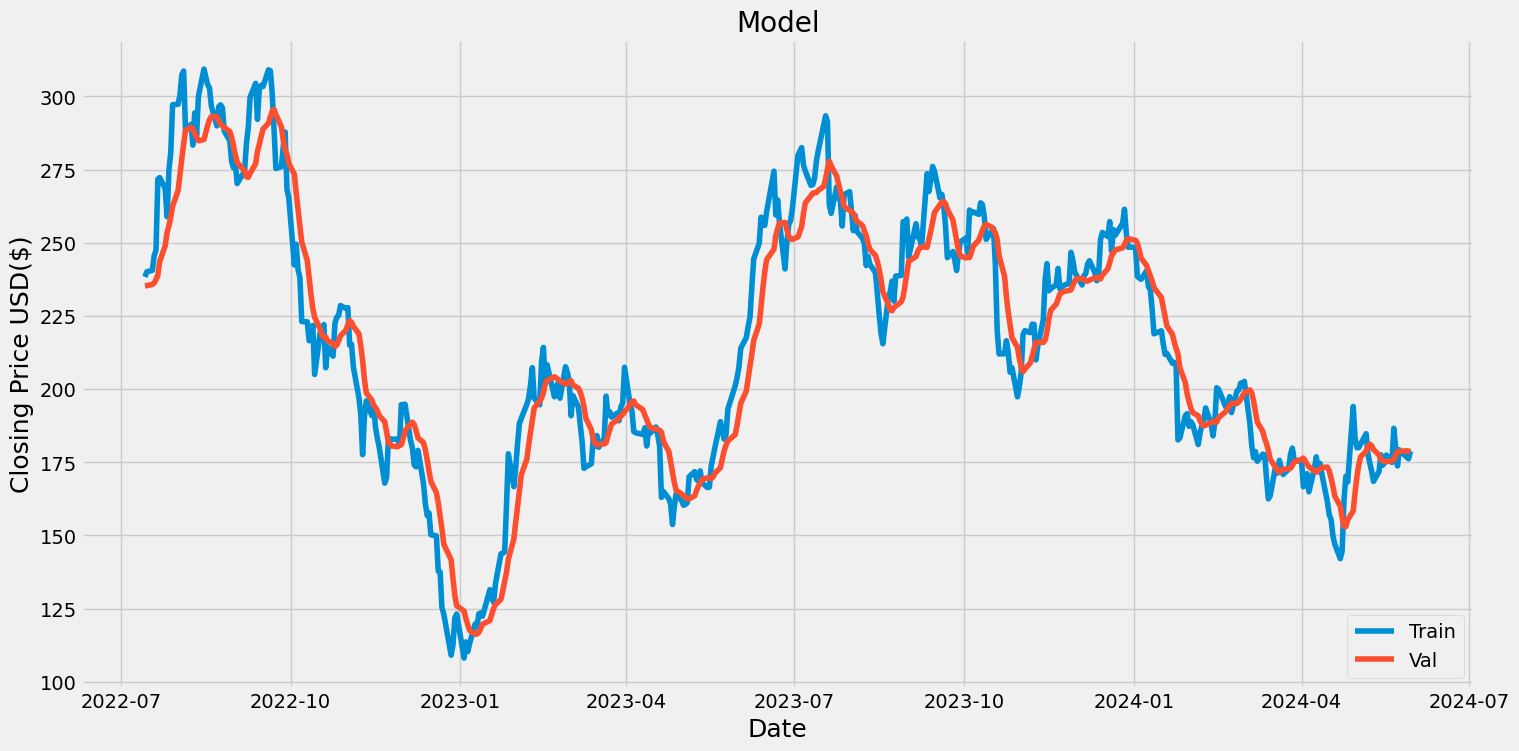

In [ ]:
# Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualising the data
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Closing Price USD($)', fontsize = 18)
#plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc = 'lower right')
plt.show()




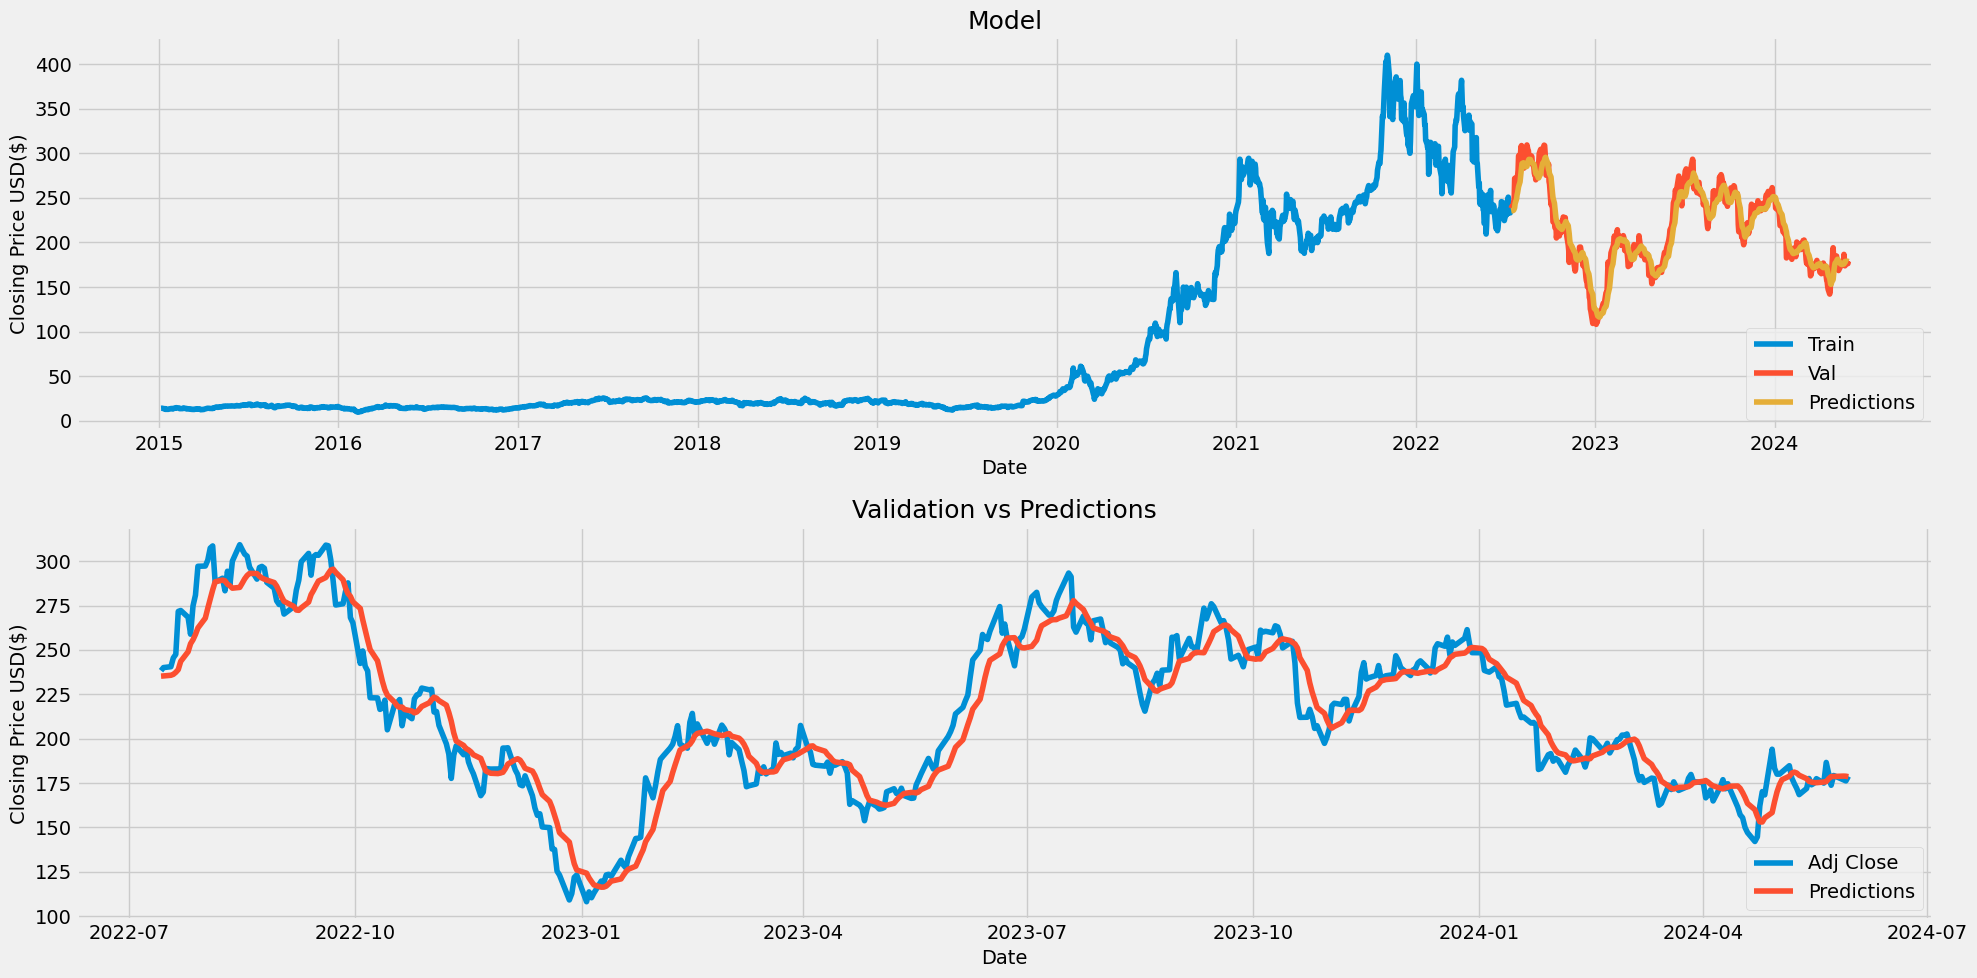

In [ ]:
# First subplot
plt.subplot(2, 1, 1)
plt.title('Model' , fontsize = 18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price USD($)', fontsize=14)
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

# Second subplot
plt.subplot(2, 1, 2)
plt.title('Validation vs Predictions' , fontsize = 18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price USD($)', fontsize=14)
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Adj Close', 'Predictions'], loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Show the valid and predicted prices
valid

,Adj Close,Predictions
Date,,
2022-07-14,238.313339,235.243988
2022-07-15,240.066666,235.347092
2022-07-18,240.546661,235.726517
2022-07-19,245.529999,236.239670
2022-07-20,247.500000,237.392548
...,...,...
2024-05-23,173.740005,178.627014
2024-05-24,179.240005,178.684570
2024-05-28,176.750000,178.904114
